# Active Kriging-Monte Carlo Simulation Example 2

Author: Katiana Kontolati \
Date: May 25, 2020

In this example, Monte Carlo Sampling is used to generate samples from Uniform distribution and new samples are generated adaptively, using EIF (Expected Improvement Function) as the learning criteria.

## Branin-Hoo function

### Decription:

>  - Dimensions: 2
>  - This function is usually evaluated on the square $x_1 \in [-5, 10], \ x_2 \in [0, 15]$
>  - The function has two local minima and one global minimum
>  - Reference: Forrester, A., Sobester, A., & Keane, A. (2008). Engineering design via surrogate modelling: a practical guide. Wiley.

> $\displaystyle f(x) = a(x_2-bx_1^2 + cx_1 -r)^2 + s(1-t)\cos(x_1) + s + 5x_1$
> <br>
> <br>
> where the recommended values of a, b, c, r, s and t are: $a = 1,\ b = 5.1/(4\pi^2),\ c = 5/\pi, \ r = 6, \ s = 10, \ t = 1/(8\pi)$

<img src="branin.png" alt="branin.png" height="350" width="400" align=left>

Import the necessary libraries. Here we import standard libraries such as numpy, matplotlib and other necessary library for plots, but also need to import the MCS, AKMCS, Kriging and RunModel class from UQpy.

In [1]:
%pylab inline
from UQpy.Surrogates import Kriging
from UQpy.SampleMethods import MCS, AKMCS
from UQpy.RunModel import RunModel
from UQpy.Distributions import Uniform
from BraninHoo import function
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import time

Populating the interactive namespace from numpy and matplotlib


Using UQpy MCS class to generate samples for two random variables, which are uniformly distributed

In [2]:
marginals = [Uniform(loc=-5, scale=15), Uniform(loc=0, scale=15)]
x = MCS(dist_object=marginals, nsamples=20)

RunModel class is used to define an object to evaluate the model at sample points.

In [3]:
rmodel = RunModel(model_script='BraninHoo.py', vec=False)

Krig class defines an object to generate an surrogate model for a given set of data.

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)
kernel = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
K = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# K = Kriging(reg_model='Linear', corr_model='Exponential', corr_model_params=np.array([1, 1]), nopt=10)

Choose an appropriate learning function.

In [5]:
learning_function = 'EIF'

AKMCS class is used to generate new sample using 'U-function' as active learning function.

In [6]:
start_time = time.time()
a = AKMCS(runmodel_object=rmodel, samples=x.samples, krig_object=K, nlearn=10**3, n_add=1, learning_function=learning_function,
          dist_object=marginals)
a.run(nsamples=90)
elapsed_time = time.time() - start_time

/usr/local/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.76594510e-05, -1.57934653e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 5.39041357e-05, -1.86899079e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.31848860e-05, -2.11427361e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: Co

In [7]:
# Test samples
x_test = MCS(dist_object=marginals, nsamples=200).samples
rmodel.run(x_test, append_samples=False)
y_test = rmodel.qoi_list
a.krig_object.score(x_test, y_test)

0.9722443276359577

Visualize initial and new samples on top of the Branin-Hoo surface.

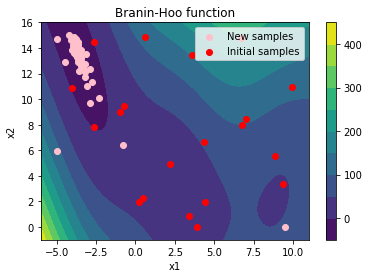

In [9]:
num = 200
xlist = np.linspace(-6, 11, num)
ylist = np.linspace(-1, 16, num)
X, Y = np.meshgrid(xlist, ylist)

Z = np.zeros((num,num))
for i in range(num):
    for j in range(num):
        tem = np.array(([X[i,j],Y[i,j]]))
        Z[i,j] = function(tem)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z,10)
xlabel('x1'); ylabel('x2')
fig.colorbar(cp)
nd = x.nsamples
scatter(a.samples[nd:, 0], a.samples[nd:, 1], color='pink', label='New samples')
scatter(x.samples[:nd, 0], x.samples[:nd, 1], color='Red', label='Initial samples')
title('Branin-Hoo function'); legend()